In [ ]:
# trying to keep all values in the NN positive
import numpy as np
import matplotlib.pyplot as plt
import torch

import numpy as np
import matplotlib.pyplot as plt
import torch 
import torchvision
import torchvision.transforms as transforms
from copy import deepcopy
import torch.nn as nn
import torch.nn.functional as F
import math
import os 
import subprocess
import time 
from datetime import datetime
import argparse
import scipy

def get_dataset(batch_size,norm_factor,dataset="mnist"):
    transform = transforms.Compose([transforms.ToTensor()])#, transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
    if dataset == "mnist":
      trainset = torchvision.datasets.MNIST(root='./mnist_data', train=True,
                                              download=True, transform=transform)
      print("trainset: ", trainset)
      trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True)
      print("trainloader: ", trainloader)
      trainset = list(iter(trainloader))

      testset = torchvision.datasets.MNIST(root='./mnist_data', train=False,
                                          download=True, transform=transform)
      testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=True)
      testset = list(iter(testloader))
      for i,(img, label) in enumerate(trainset):
          trainset[i] = (img.reshape(len(img),784) /norm_factor ,label)
      for i,(img, label) in enumerate(testset):
          testset[i] = (img.reshape(len(img),784) /norm_factor ,label)
      return trainset, testset
    elif dataset == "fashion":
      trainset = torchvision.datasets.FashionMNIST(root='./fashion_data', train=True,
                                            download=True, transform=transform)
      print("trainset: ", trainset)
      trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=False)
      print("trainloader: ", trainloader)
      trainset = list(iter(trainloader))

      testset = torchvision.datasets.FashionMNIST(root='./fashion_data', train=False,
                                          download=True, transform=transform)
      testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=True)
      testset = list(iter(testloader))
      for i,(img, label) in enumerate(trainset):
          trainset[i] = (img.reshape(len(img),784) /norm_factor ,label)
      for i,(img, label) in enumerate(testset):
          testset[i] = (img.reshape(len(img),784) /norm_factor ,label)
      return trainset, testset
    else:
      return ValueError("Dataset not found")

def np_norm(x):
      return np.linalg.norm(x.numpy())

def onehot(x):
    z = torch.zeros([len(x),10])
    for i in range(len(x)):
      z[i,x[i]] = 1
    return z.float().to(DEVICE)


### functions ###
def set_tensor(xs):
  return xs.float().to(DEVICE)

def tanh(xs):
    return torch.tanh(xs)

def tanh_plus_1(xs):
  return torch.tanh(xs) + 1



def linear(x):
    return x

def tanh_deriv(xs):
    return 1.0 - torch.tanh(xs) ** 2.0

def linear_deriv(x):
    return set_tensor(torch.ones_like((x)))

def relu(xs):
  return torch.clamp(xs,min=0)

def relu_deriv(xs):
  rel = relu(xs)
  rel[rel>0] = 1
  return rel 

def softmax(xs):
  return F.softmax(xs)

def sigmoid(xs):
  return F.sigmoid(xs)

def sigmoid_deriv(xs):
  return F.sigmoid(xs) * (torch.ones_like(xs) - F.sigmoid(xs))
   

def accuracy(out, L):
  if len(L.shape) == 1:
    # i.e. not onehotted
    L = onehot(L)
  B,l = out.shape
  total = 0
  for i in range(B):
    if torch.argmax(out[i,:]) == torch.argmax(L[i,:]):
      total +=1
  return total/ B

### loss functions
def mse_loss(out, label):
      return torch.sum((out-label)**2)

def mse_deriv(out,label):
      return 2 * (out - label)

ce_loss = nn.CrossEntropyLoss()

def cross_entropy_loss(out,label):
      return ce_loss(out,label)

def my_cross_entropy(out,label):
      return -torch.sum(label * torch.log(out + 1e-6))

def cross_entropy_deriv(out,label):
      return out - label

def parse_loss_function(loss_arg):
      if loss_arg == "mse":
            return mse_loss, mse_deriv
      elif loss_arg == "crossentropy":
            return my_cross_entropy, cross_entropy_deriv
      else:
            raise ValueError("loss argument not expected. Can be one of 'mse' and 'crossentropy'. You inputted " + str(loss_arg))


def boolcheck(x):
    return str(x).lower() in ["true", "1", "yes"]


class FCLayer(object):
  def __init__(self, input_size, output_size,batch_size, fn, fn_deriv,use_layer_norm=True,device='cpu'):
    self.input_size = input_size
    self.output_size = output_size
    self.batch_size = batch_size
    self.fn = fn
    self.fn_deriv = fn_deriv
    self.device = device
    self.weights = torch.empty((self.input_size, self.output_size)).normal_(0.0,0.05).float().to(self.device)
    self.bias = torch.zeros((self.batch_size, self.output_size)).float().to(self.device)
    self.weights = nn.Parameter(self.weights)
    self.bias = nn.Parameter(self.bias)
    self.use_layer_norm = use_layer_norm
    self.layer_norm = torch.nn.LayerNorm(output_size)

  def forward(self, x):
    self.activations = x @ torch.exp(self.weights)#F.softmax(self.weights) # works with softmax and exponential, to maintain the synaptic weight positivity. Exp is better since it is local vs softmax which needs a sum over all other weights
    #print("weights: ",(torch.exp(self.weights) <0).any()) # so this works!
    #print("activations: ", (self.activations <0).any())
    if (self.activations < 0).any():
      print("Negative found!")
      print(self.activations)
      print(x)
      print(torch.exp(self.weights))
      crash
    self.outs = self.activations + torch.exp(self.bias)
    #print("outs: ", (self.outs < 0).any())
    if self.use_layer_norm:
      return self.fn(self.layer_norm(self.outs))
    else:
      return self.fn(self.outs)


class BackpropNet(object):
    def __init__(self, layers,loss_fn=None,device="cpu"):
        self.layers = layers
        self.device = device
        self.loss_fn = loss_fn

    def forward(self,x):
        for i,l in enumerate(self.layers):
            x = l.forward(x)
        return x

    def zero_grad(self):
        for l in self.layers:
            l.weights.grad = torch.zeros_like(l.weights).to(l.device)

    def train(self, trainset, testset,logdir,savedir, num_epochs,learning_rate,test=True):
      losses = []
      accs = []
      test_accs = []
      mean_train_accs = []
      mean_test_accs = []
      #begin training loop
      for n_epoch in range(num_epochs):
          epoch_train_accs = []
          print("Beginning epoch ",n_epoch)
          losslist = []
          acclist = []
          for n,(img,label) in enumerate(trainset):
              img = img.to(self.device)
              if self.loss_fn != cross_entropy_loss:
                label = onehot(label).to(self.device)
              else:
                    label = label.long().to(self.device)
              pred_outs = self.forward(img)
              if self.loss_fn:
                    L = self.loss_fn(pred_outs, label)
              else:
                    L = torch.sum((pred_outs - label)**2)
              L.backward()
              acc = accuracy(pred_outs,label)
              print("epoch: " + str(n_epoch) + " loss batch " + str(n) + "  " + str(L))
              print("acc batch " + str(n) + "  " + str(acc))
              losslist.append(L.item())
              acclist.append(acc)
              epoch_train_accs.append(accs)
              #update
              for l in self.layers:
                  #SGD update
                  lgrad = l.weights.grad.clone()
                  #print(lgrad)
                  l.weights = l.weights.detach().clone()
                  l.weights -= learning_rate  * lgrad
                  l.weights = nn.Parameter(l.weights)
              #zero grad weights just to be sure
          self.zero_grad()
          mean_train_accs.append(np.mean(np.array(epoch_train_accs)))
          if test:
              with torch.no_grad():
                  epoch_test_accs = []
                  for tn, (test_img, test_label) in enumerate(testset):
                      test_img = test_img.to(self.device)
                      labels = onehot(test_label).to(self.device)
                      pred_outs = self.forward(test_img)
                      test_acc = accuracy(pred_outs, labels)
                      test_accs.append(test_acc)
                      epoch_test_accs.append(test_acc)
          losses.append(np.mean(np.array(losslist)))
          accs.append(np.mean(np.array(acclist)))
          mean_test_accs.append(np.mean(np.array(epoch_test_accs)))
          #self.save_model(logdir,savedir,losses,accs,test_accs,mean_test_accs, mean_train_accs)
      if test:
          return losses, accs, test_accs
      else:
          return losses, accs

if __name__ == '__main__':
    global DEVICE
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_size  = 64
    learning_rate = 0.0001
    N_epochs = 50
    loss_fn_name = "crossentropy"
    dataset = "fashion"
    logdir = "/logs"
    savedir = "/save"
    f = tanh_plus_1
    df = tanh_deriv

    loss_fn = None
    if loss_fn != "":
          loss_fn,loss_fn_deriv = parse_loss_function(loss_fn_name)
    trainset,testset = get_dataset(batch_size,1,dataset=dataset)
    l1 = FCLayer(784,300,batch_size,f,df,device=DEVICE)
    l2 = FCLayer(300,300,batch_size,f,df,device=DEVICE)
    l3 = FCLayer(300,100,batch_size,f,df,device=DEVICE)
    if loss_fn_name == "crossentropy":
      l4 = FCLayer(100,10,batch_size,softmax,linear_deriv,device=DEVICE,use_layer_norm=False)
    else:
      l4 = FCLayer(100,10,batch_size,linear,linear_deriv,device=DEVICE,use_layer_norm=False)

    layers =[l1,l2,l3,l4]
    net = BackpropNet(layers,loss_fn=loss_fn,device=DEVICE)
    net.train(trainset[0:-2],testset[0:-2],logdir,savedir,N_epochs,learning_rate)

Extracting ./fashion_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./fashion_data/FashionMNIST/raw


Extracting ./fashion_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./fashion_data/FashionMNIST/raw


Extracting ./fashion_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./fashion_data/FashionMNIST/raw


Extracting ./fashion_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./fashion_data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


trainset:  Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./fashion_data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
trainloader:  <torch.utils.data.dataloader.DataLoader object at 0x7f20a1a7d940>


Beginning epoch  0
weights:  tensor(False)
activations:  tensor(False)
outs:  tensor(False)
weights:  tensor(False)
activations:  tensor(False)
outs:  tensor(False)
weights:  tensor(False)
activations:  tensor(False)
outs:  tensor(False)
weights:  tensor(False)
activations:  tensor(False)
outs:  tensor(False)
epoch: 0 loss batch 0  tensor(156.8396, grad_fn=<NegBackward>)
acc batch 0  0.0625
weights:  tensor(False)
activations:  tensor(False)
outs:  tensor(False)
weights:  tensor(False)
activations:  tensor(False)
outs:  tensor(False)
weights:  tensor(False)
activations:  tensor(False)
outs:  tensor(False)
weights:  tensor(False)
activations:  tensor(False)
outs:  tensor(False)
epoch: 0 loss batch 1  tensor(152.91

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Streaming output truncated to the last 5000 lines.
outs:  tensor(False)
weights:  tensor(False)
activations:  tensor(False)
outs:  tensor(False)
epoch: 0 loss batch 588  tensor(33.0291, grad_fn=<NegBackward>)
acc batch 588  0.90625
weights:  tensor(False)
activations:  tensor(False)
outs:  tensor(False)
weights:  tensor(False)
activations:  tensor(False)
outs:  tensor(False)
weights:  tensor(False)
activations:  tensor(False)
outs:  tensor(False)
weights:  tensor(False)
activations:  tensor(False)
outs:  tensor(False)
epoch: 0 loss batch 589  tensor(41.8385, grad_fn=<NegBackward>)
acc batch 589  0.71875
weights:  tensor(False)
activations:  tensor(False)
outs:  tensor(False)
weights:  tensor(False)
activations:  tensor(False)
outs:  tensor(False)
weights:  tensor(False)
activations:  tensor(False)
outs:  tensor(False)
weights:  tensor(False)
activations:  tensor(False)
outs:  tensor(False)
epoch: 0 loss batch 590  tensor(39.2201, grad_fn=<NegBackward>)
acc batch 590  0.796875
weights: 

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Streaming output truncated to the last 5000 lines.
weights:  tensor(False)
activations:  tensor(False)
outs:  tensor(False)
epoch: 1 loss batch 884  tensor(32.9163, grad_fn=<NegBackward>)
acc batch 884  0.796875
weights:  tensor(False)
activations:  tensor(False)
outs:  tensor(False)
weights:  tensor(False)
activations:  tensor(False)
outs:  tensor(False)
weights:  tensor(False)
activations:  tensor(False)
outs:  tensor(False)
weights:  tensor(False)
activations:  tensor(False)
outs:  tensor(False)
epoch: 1 loss batch 885  tensor(30.6382, grad_fn=<NegBackward>)
acc batch 885  0.84375
weights:  tensor(False)
activations:  tensor(False)
outs:  tensor(False)
weights:  tensor(False)
activations:  tensor(False)
outs:  tensor(False)
weights:  tensor(False)
activations:  tensor(False)
outs:  tensor(False)
weights:  tensor(False)
activations:  tensor(False)
outs:  tensor(False)
epoch: 1 loss batch 886  tensor(27.3067, grad_fn=<NegBackward>)
acc batch 886  0.875
weights:  tensor(False)
activati

KeyboardInterrupt: ignored

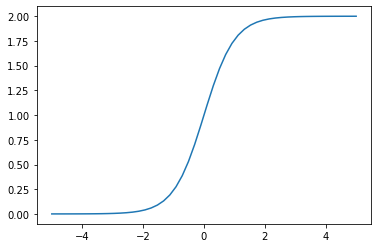

In [ ]:
# check activation functions
import numpy as np
import matplotlib.pyplot as plt

def tanh_mult(x):
  return np.tanh(x) * 5

def tanh_plus_1(x):
  return np.tanh(x) + 1

xs = np.linspace(-5,5,num=50)
ys = [tanh_plus_1(x) for x in xs]
plt.plot(xs,ys)
plt.show()